In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import Dataset
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import random


In [2]:
df_bbox = pd.read_csv('Periocular  - bbox.csv', delimiter=',')
df_bbox.info()
df_landmarks = pd.read_csv('Periocular  - landmarks.csv', delimiter=',')
df_landmarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1000 non-null   object
 1   x_1       1000 non-null   int64 
 2   y_1       1000 non-null   int64 
 3   width     1000 non-null   int64 
 4   height    1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      1000 non-null   object
 1   lefteye_x     1000 non-null   int64 
 2   lefteye_y     1000 non-null   int64 
 3   righteye_x    1000 non-null   int64 
 4   righteye_y    1000 non-null   int64 
 5   nose_x        1000 non-null   int64 
 6   nose_y        1000 non-null   int64 
 7   leftmouth_x   1000 non-null   int64 
 8   leftmouth_y   1000 non-null   int64 
 9   right

In [3]:
df_landmarks.head(10)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150
5,000006.jpg,71,111,106,110,94,131,74,154,102,153
6,000007.jpg,70,112,108,111,85,135,72,152,104,152
7,000008.jpg,71,110,106,111,84,137,73,155,104,153
8,000009.jpg,68,113,110,111,97,139,66,152,109,150
9,000010.jpg,68,111,108,112,89,136,70,151,107,151


In [4]:
df_bbox.head(10)

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166
5,000006.jpg,146,67,182,252
6,000007.jpg,64,93,211,292
7,000008.jpg,212,89,218,302
8,000009.jpg,600,274,343,475
9,000010.jpg,113,110,211,292


In [5]:
df_bbox['base_id'] = df_bbox['image_id'].str.replace('-with-mask', '', regex=False)
df_landmarks['base_id'] = df_landmarks['image_id']

In [6]:
# Merge datasets on base_id
paired_data = pd.merge(df_bbox, df_landmarks, on='base_id', suffixes=('_masked', '_unmasked'))
paired_data.head()
paired_data['image_id_masked'] = paired_data['image_id_masked'].apply(lambda x: f"img{x.split('.')[0]}-with-mask.jpg")
paired_data['image_id_unmasked'] = paired_data['image_id_unmasked'].apply(lambda x: f"img{x.split('.')[0]}.jpg")

paired_data.head()


,image_id_masked,x_1,y_1,width,height,base_id,image_id_unmasked,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,img000001-with-mask.jpg,95,71,226,313,000001.jpg,img000001.jpg,69,109,106,113,77,142,73,152,108,154
1,img000002-with-mask.jpg,72,94,221,306,000002.jpg,img000002.jpg,69,110,107,112,81,135,70,151,108,153
2,img000003-with-mask.jpg,216,59,91,126,000003.jpg,img000003.jpg,76,112,104,106,108,128,74,156,98,158
3,img000004-with-mask.jpg,622,257,564,781,000004.jpg,img000004.jpg,72,113,108,108,101,138,71,155,101,151
4,img000005-with-mask.jpg,236,109,120,166,000005.jpg,img000005.jpg,66,114,112,112,86,119,71,147,104,150


In [7]:


class MaskedFaceDataset(Dataset):
    def __init__(self, paired_data, images_path, transform=None):
        self.paired_data = paired_data
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.paired_data)

    def __getitem__(self, idx):
        row = self.paired_data.iloc[idx]
        
        try:
            # Load masked image
            masked_path = os.path.join(self.images_path, row['image_id_masked'])
            masked_img = Image.open(masked_path).convert("RGB")
            
            # Crop masked image using bounding box data
            x1, y1, width, height = row['x_1'], row['y_1'], row['width'], row['height']
            masked_img = masked_img.crop((x1, y1, x1 + width, y1 + height))

            # Load unmasked image
            unmasked_path = os.path.join(self.images_path, row['image_id_unmasked'])
            unmasked_img = Image.open(unmasked_path).convert("RGB")

            # Apply transformations
            if self.transform:
                masked_img = self.transform(masked_img)
                unmasked_img = self.transform(unmasked_img)

            return masked_img, unmasked_img, row['base_id']

        except (FileNotFoundError, UnidentifiedImageError) as e:
           # print(f"Skipping missing or invalid image: {e}")
            # If an image is missing, skip this sample
            return self.__getitem__((idx + 1) % len(self))



In [8]:
class FaceEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=128):
        super(FaceEmbeddingModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  
        
        self.embedding = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        features = self.backbone(x)      
        embeddings = self.embedding(features)  
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1) 
        return embeddings

In [9]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, label):
        distance = torch.nn.functional.pairwise_distance(embedding1, embedding2)
        
        loss = (1 - label) * torch.pow(distance, 2) + \
               label * torch.pow(torch.clamp(self.margin - distance, min=0), 2)
        
        return torch.mean(loss)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.1468
Epoch [2/5], Loss: 0.0697
Epoch [3/5], Loss: 0.0792
Epoch [4/5], Loss: 0.0493
Epoch [5/5], Loss: 0.0498


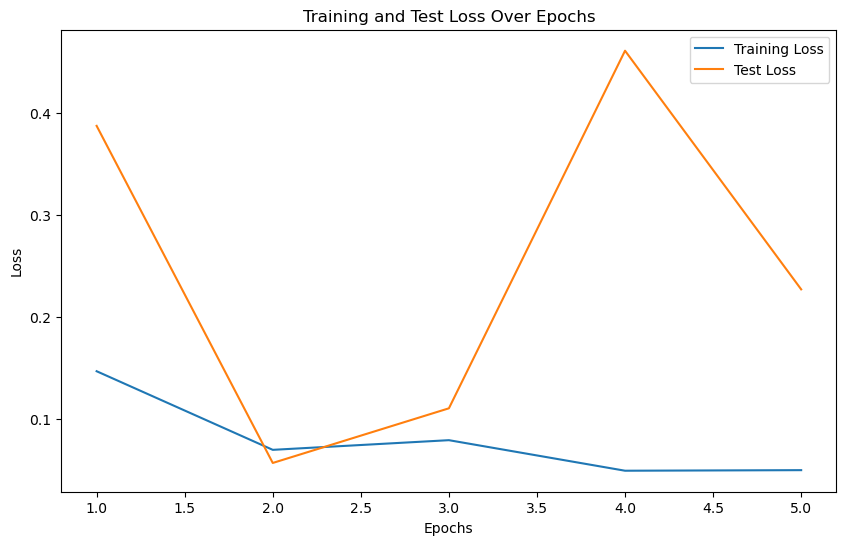

In [10]:
images_path ='Dataset/Dataset'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_data, test_data = train_test_split(paired_data, test_size=0.2, random_state=42)

batch_size = 8
train_dataset = MaskedFaceDataset(train_data, images_path, transform)
test_dataset = MaskedFaceDataset(test_data, images_path, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceEmbeddingModel(embedding_dim=128).to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5
train_losses = []
test_losses = []


for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for masked_img, unmasked_img, _ in train_loader:
        masked_img = masked_img.to(device)
        unmasked_img = unmasked_img.to(device)

        embedding_masked = model(masked_img)
        embedding_unmasked = model(unmasked_img)

        labels = torch.ones(masked_img.size(0)).to(device)  
        loss = criterion(embedding_masked, embedding_unmasked, labels)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    model.eval()  
    epoch_test_loss = 0.0
    with torch.no_grad():  
        for masked_img, unmasked_img, _ in test_loader:
            masked_img = masked_img.to(device)
            unmasked_img = unmasked_img.to(device)

            embedding_masked = model(masked_img)
            embedding_unmasked = model(unmasked_img)

            labels = torch.ones(masked_img.size(0)).to(device)
            loss = criterion(embedding_masked, embedding_unmasked, labels)
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.show()

In [11]:
def visualize_embeddings(model, dataloader, title, n_ids=5):
    model.eval()
    embeddings, labels = [], []
    selected_ids = set()

    with torch.no_grad():
        for masked_img, unmasked_img, base_id in dataloader:
            masked_img = masked_img.to(device)
            unmasked_img = unmasked_img.to(device)

            masked_embedding = model(masked_img).cpu().numpy()
            unmasked_embedding = model(unmasked_img).cpu().numpy()

            embeddings.extend(masked_embedding)
            embeddings.extend(unmasked_embedding)

            labels.extend([f"{id}_masked" for id in base_id])
            labels.extend([f"{id}_unmasked" for id in base_id])

            # Randomly choose IDs for visualization
            if len(selected_ids) < n_ids:
                selected_ids.update(base_id)

    # Filter selected IDs
    filtered_embeddings = []
    filtered_labels = []
    for emb, label in zip(embeddings, labels):
        base_id = label.split("_")[0]
        if base_id in selected_ids:
            filtered_embeddings.append(emb)
            filtered_labels.append(label)

    # PCA Dimensionality Reduction
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(filtered_embeddings)

    # Plot
    plt.figure(figsize=(12, 8))
    for label in selected_ids:
        masked_indices = [i for i, l in enumerate(filtered_labels) if l == f"{label}_masked"]
        unmasked_indices = [i for i, l in enumerate(filtered_labels) if l == f"{label}_unmasked"]

        plt.scatter(reduced_embeddings[masked_indices, 0], reduced_embeddings[masked_indices, 1],
                    label=f"{label} Masked", marker='x')
        plt.scatter(reduced_embeddings[unmasked_indices, 0], reduced_embeddings[unmasked_indices, 1],
                    label=f"{label} Unmasked", marker='o')

    plt.title(title)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")

    # Place legend outside the plot
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=8, markerscale=0.5)
    plt.tight_layout()  # Adjust layout to make space for legend
    plt.show()


/var/folders/dv/nkl_r9ks6791vrcrfs6dkfcr0000gp/T/ipykernel_40837/3781509191.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to make space for legend


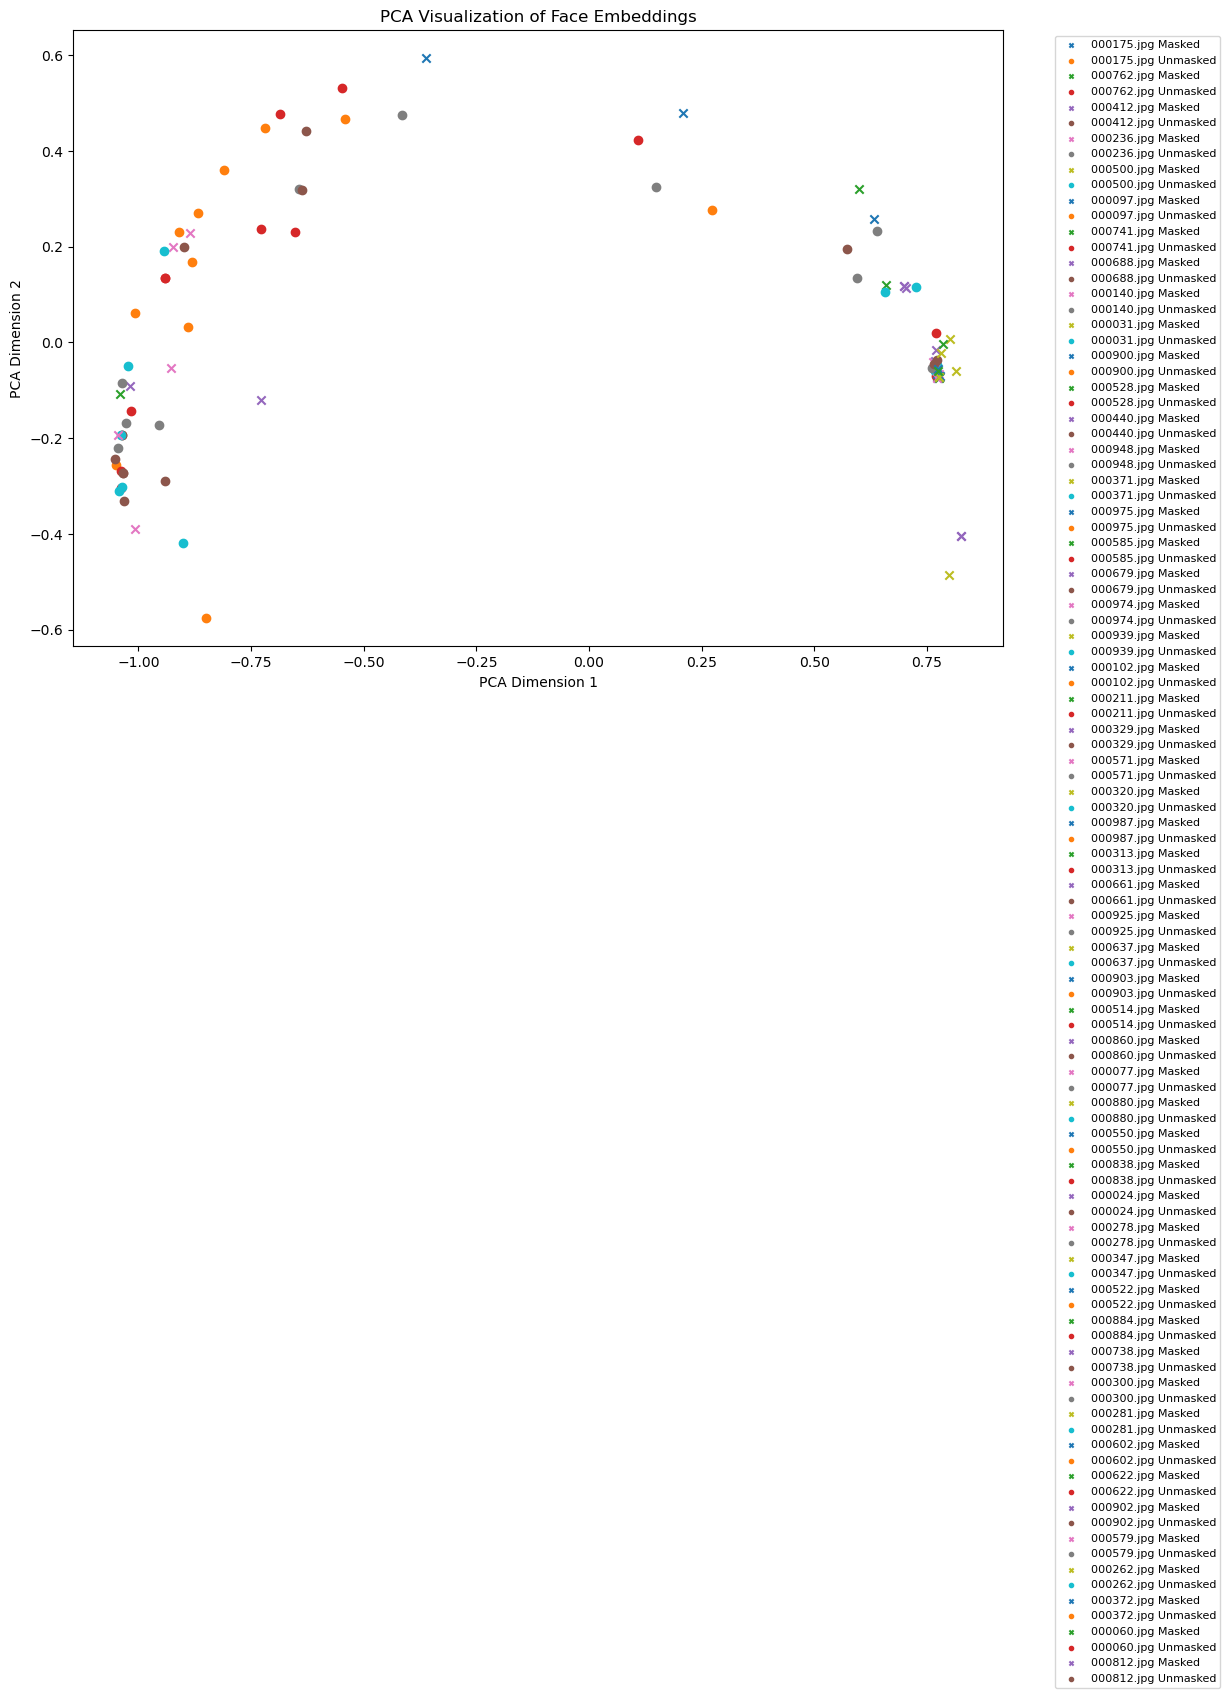

In [12]:
visualize_embeddings(
    model=model,                
    dataloader=test_loader,  
    title="PCA Visualization of Face Embeddings", 
    n_ids=50)                   


B-1

# Data Handling: Paired images based on IDs and handled missing images by skipping them during loading.
# Model Design: Used a CNN to learn embeddings, minimizing distances for matching pairs and maximizing for non-matching ones.
# Evaluation: Visualized embeddings in 2D using PCA and tested the model on unseen data.

# Conclusion
The model effectively linked masked and unmasked faces, showing potential for real-world applications. Improvements with a larger dataset or advanced architectures could further enhance accuracy.